In [1]:
import pandas as pd
import joblib
import numpy as np

# 1. Load the Tabular Data (the Excel info)
# This contains the original columns + your engineered features
df_final = pd.read_csv('processed_house_data.csv')

# 2. Load the Scaled Feature Matrix (X)
# These are the 50+ features processed for the Neural Network
X_scaled = joblib.load('X_scaled_final.joblib')

# 3. Load the Target Prices (y)
# These are the Log-Transformed prices
y_target = joblib.load('y_target_final.joblib')

# 4. Load the Scaler
# We need this later to "un-scale" predictions for our report
scaler = joblib.load('price_scaler.joblib')

print("--- Data Import Successful ---")
print(f"Total Houses Loaded: {len(df_final)}")
print(f"Features in Matrix:  {X_scaled.shape[1]}")
print(f"Target values:       {len(y_target)}")

# Quick verification: Check the first 5 IDs to ensure they match your folder
print(f"\nSample IDs for matching images: {df_final['id'].head().tolist()}")

--- Data Import Successful ---
Total Houses Loaded: 16110
Features in Matrix:  22
Target values:       16110

Sample IDs for matching images: [9117000170, 6700390210, 7212660540, 8562780200, 7760400350]


In [2]:
from sklearn.model_selection import train_test_split

# We split the scaled features (X) and the log-prices (y)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_target, test_size=0.2, random_state=42
)

print(f"Training on {len(X_train)} houses.")
print(f"Testing on {len(X_test)} houses.")

Training on 12888 houses.
Testing on 3222 houses.


In [4]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# 1. Initialize the model
model_tabular = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

# 2. Train the model
print("Training Tabular Model...")
model_tabular.fit(X_train, y_train)

# 3. Predict on the test set
y_pred_log = model_tabular.predict(X_test)

# 4. Convert log-predictions back to actual Dollar amounts
y_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

# 5. Calculate Performance Metrics
r2 = r2_score(y_actual, y_pred_actual)
mae = mean_absolute_error(y_actual, y_pred_actual)
mse = mean_squared_error(y_actual, y_pred_actual)
rmse = np.sqrt(mse) # Square root of MSE gives us RMSE

print(f"\n--- TABULAR MODEL RESULTS ---")
print(f"R² Score: {r2:.4f}")
print(f"Typical Error (MAE): ${mae:,.2f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:,.2f}")

Training Tabular Model...

--- TABULAR MODEL RESULTS ---
R² Score: 0.9129
Typical Error (MAE): $60,143.15
RMSE (Root Mean Squared Error): $103,185.87


In [18]:
from sklearn.model_selection import train_test_split

# 1. We create a list of indices (0 to 16109)
indices = np.arange(len(df_final))

# 2. Split the indices instead of the data
# This ensures we can match the Image IDs with the Tabular Rows perfectly
train_idx, val_idx = train_test_split(
    indices, test_size=0.2, random_state=42
)

# 3. Now re-assign the labels for the generators
y_train = y_target[train_idx]
y_test = y_target[val_idx]

print(f"Indices defined: {len(train_idx)} training, {len(val_idx)} validation.")

Indices defined: 12887 training, 3222 validation.


In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import UnidentifiedImageError # Add this import specifically

class ImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids, labels, image_folder, batch_size=32, target_size=(224, 224)):
        self.ids = ids
        self.labels = labels
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.ids[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        images = []
        for img_id in batch_ids:
            path = os.path.join(self.image_folder, f"{img_id}.jpg")
            try:
                # Attempt to load the image
                img = load_img(path, target_size=self.target_size)
                img = img_to_array(img) / 255.0
                images.append(img)
            except (UnidentifiedImageError, IOError, Exception) as e:
                # If image is broken, print which one it is and use a blank image instead
                print(f"Skipping corrupted image {img_id}.jpg: {e}")
                images.append(np.zeros((self.target_size[0], self.target_size[1], 3)))
            
        return np.array(images), np.array(batch_labels)

In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def build_vision_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False # We use Google's pre-trained 'knowledge'
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1) # Predicting the log_price
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

vision_model = build_vision_model()
print("Vision Model ready for training!")

Vision Model ready for training!


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define Early Stopping
# 'val_loss' is the error on the test set
# 'patience=2' means stop if no improvement for 2 epochs
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    restore_best_weights=True,
    verbose=1
)

# 2. Start Training
# We can set epochs to 10 safely now, because EarlyStopping will likely 
# kill the process around epoch 4 or 5.
history_vision = vision_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10, 
    callbacks=[early_stop],
    verbose=1
)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 287s 698ms/step - loss: 9.9243 - mae: 2.0816 - val_loss: 1.2028 - val_mae: 0.8754
Epoch 2/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 331s 721ms/step - loss: 2.5054 - mae: 1.2606 - val_loss: 0.8375 - val_mae: 0.7239
Epoch 3/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 294s 731ms/step - loss: 2.2344 - mae: 1.1879 - val_loss: 0.8750 - val_mae: 0.7329
Epoch 4/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 324s 805ms/step - loss: 2.2237 - mae: 1.1832 - val_loss: 0.9895 - val_mae: 0.7861
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [16]:
import os
from PIL import Image

image_folder = 'house_images'
corrupted_ids = []

print("Scanning for corrupted images...")
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):
        path = os.path.join(image_folder, filename)
        try:
            with Image.open(path) as img:
                img.verify() # This checks if the file is a valid image
        except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
            print(f"Bad image found: {filename}")
            corrupted_ids.append(filename.replace('.jpg', ''))

print(f"\nScan complete. Found {len(corrupted_ids)} corrupted images.")

Scanning for corrupted images...
Bad image found: 3336000791.jpg

Scan complete. Found 1 corrupted images.


In [17]:
if len(corrupted_ids) > 0:
    # Filter out the corrupted IDs from our main DataFrame
    df_final = df_final[~df_final['id'].astype(str).isin(corrupted_ids)].reset_index(drop=True)
    
    # Re-run the split to ensure indices match the new length
    indices = np.arange(len(df_final))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    # Re-assign IDs and Labels
    train_ids = df_final.iloc[train_idx]['id'].values
    test_ids = df_final.iloc[val_idx]['id'].values
    y_train = y_target[train_idx]
    y_test = y_target[val_idx]
    
    # Re-initialize Generators
    train_gen = ImageGenerator(train_ids, y_train, 'house_images')
    test_gen = ImageGenerator(test_ids, y_test, 'house_images')
    
    print(f"Data cleaned! New total houses: {len(df_final)}")
else:
    print("No corruption found in the current list. Try re-running the training.")

Data cleaned! New total houses: 16109


In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Get predictions from the Vision Model (in Log scale)
# test_gen contains the images the model has NEVER seen
y_pred_vision_log = vision_model.predict(test_gen)

# 2. Convert back to actual prices (Exponentials)
# We use y_test which we defined during the split
y_actual_dollars = np.expm1(y_test)
y_pred_vision_dollars = np.expm1(y_pred_vision_log).flatten()

# 3. Calculate Scores
vision_r2 = r2_score(y_actual_dollars, y_pred_vision_dollars)
vision_rmse = np.sqrt(mean_squared_error(y_actual_dollars, y_pred_vision_dollars))
vision_mae = mean_absolute_error(y_actual_dollars, y_pred_vision_dollars)

print(f"--- VISION-ONLY MODEL RESULTS ---")
print(f"R² Score: {vision_r2:.4f}")
print(f"Mean Absolute Error: ${vision_mae:,.2f}")
print(f"RMSE (Avg Error): ${vision_rmse:,.2f}")

101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 374ms/step
--- VISION-ONLY MODEL RESULTS ---
R² Score: -1.0854
Mean Absolute Error: $344,782.49
RMSE (Avg Error): $518,983.36


In [27]:
import tensorflow as tf
from tensorflow.keras import Model

# 1. Access the first layer (MobileNetV2 base) and second layer (Pooling) directly
# vision_model.layers[0] is the MobileNetV2 base model
# vision_model.layers[1] is the GlobalAveragePooling2D layer
vision_input = vision_model.layers[0].input
vision_output = vision_model.layers[1].output

# 2. Build the model using these specific tensors
feature_extractor = Model(inputs=vision_input, outputs=vision_output)

print(f"Success! Feature Extractor created manually.")
print(f"Extraction layer name: {vision_model.layers[1].name}")

Success! Feature Extractor created manually.
Extraction layer name: global_average_pooling2d_3


In [31]:
import numpy as np
import tensorflow as tf

# 1. Initialize an empty list to store features
all_features = []

print("Starting manual feature extraction...")
print(f"Total batches to process: {len(full_gen)}")

# 2. Loop through the generator manually
for i in range(len(full_gen)):
    # Get a batch of images
    imgs, _ = full_gen[i]
    
    # Pass images through the layers of vision_model manually
    # Layer 0 is MobileNet, Layer 1 is GlobalAveragePooling
    x = vision_model.layers[0](imgs)
    x = vision_model.layers[1](x)
    
    # Convert the tensor to a numpy array and store it
    all_features.append(x.numpy())
    
    if (i + 1) % 50 == 0:
        print(f"Processed {i + 1}/{len(full_gen)} batches...")

# 3. Stack everything into one giant matrix
visual_features = np.vstack(all_features)

print(f"Extraction complete! Matrix shape: {visual_features.shape}")

Starting manual feature extraction...
Total batches to process: 504
Processed 50/504 batches...
Processed 100/504 batches...
Processed 150/504 batches...
Processed 200/504 batches...
Processed 250/504 batches...
Processed 300/504 batches...
Processed 350/504 batches...
Processed 400/504 batches...
Processed 450/504 batches...
Processed 500/504 batches...
Extraction complete! Matrix shape: (16109, 1280)


In [33]:
import pandas as pd

# 1. Convert the 1,280 features into a DataFrame
visual_df = pd.DataFrame(visual_features)
visual_df.columns = [f'vis_{i}' for i in range(visual_df.shape[1])]

# i reset the index to ensure the rows match up perfectly
df_multimodal = pd.concat([df_final.reset_index(drop=True), visual_df], axis=1)

print(f"Dataset Merged! New Shape: {df_multimodal.shape}")

Dataset Merged! New Shape: (16109, 1316)


In [37]:
import xgboost as xgb
from sklearn.metrics import r2_score
import numpy as np

# 1. Get ONLY the numeric columns (this automatically drops 'date' and any other text)
X_multi_numeric = df_multimodal.select_dtypes(include=[np.number])

# 2. Drop the target variables from X (the features)
# We drop 'price' and 'log_price' if they are in the dataframe
cols_to_drop = ['price', 'log_price', 'id']
X_multi = X_multi_numeric.drop(columns=[c for c in cols_to_drop if c in X_multi_numeric.columns])

# 3. Use your y_target (which is already numeric log_prices)
y_multi = y_target 

# 4. Use your indices to split
X_train_m = X_multi.iloc[train_idx]
X_test_m = X_multi.iloc[val_idx]
y_train_m = y_multi[train_idx]
y_test_m = y_multi[val_idx]

print(f"Training on {X_train_m.shape[1]} numeric features...")

# 5. Train the Final Model
final_model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8
)
final_model.fit(X_train_m, y_train_m)

# 6. Evaluation
final_preds_log = final_model.predict(X_test_m)
final_preds_actual = np.expm1(final_preds_log)
y_true_actual = np.expm1(y_test_m)

final_r2 = r2_score(y_true_actual, final_preds_actual)
print(f"\n--- FINAL MULTI-MODAL RESULTS ---")
print(f"Final R² Score: {final_r2:.5f}")

Training on 1313 numeric features...

--- FINAL MULTI-MODAL RESULTS ---
Final R² Score: -0.03368


In [39]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
from sklearn.metrics import r2_score

# 1. Synchronize: Ensure y_multi matches the 16,109 rows in X_multi
# We use the index of X_multi to slice y_target
y_multi_sync = y_target[:len(X_multi)] 

# 2. Separate Tabular and Visual features
tabular_cols = [c for c in X_multi.columns if not c.startswith('vis_')]
visual_cols = [c for c in X_multi.columns if c.startswith('vis_')]

X_tab = X_multi[tabular_cols]
X_vis = X_multi[visual_cols]

# 3. Pick only the TOP 50 visual features
# This helps the model focus on 'Signal' instead of 'Noise'
selector = SelectKBest(score_func=f_regression, k=50)
X_vis_reduced = selector.fit_transform(X_vis, y_multi_sync)
selected_vis_names = [visual_cols[i] for i in selector.get_support(indices=True)]
X_vis_reduced_df = pd.DataFrame(X_vis_reduced, columns=selected_vis_names)

# 4. Combine Tabular + the BEST 50 Vision features
X_final_hybrid = pd.concat([X_tab.reset_index(drop=True), X_vis_reduced_df], axis=1)

# 5. Split and Train (Using the synced y)
# We need to re-define the split indices since the length changed by 1
from sklearn.model_selection import train_test_split
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_final_hybrid, y_multi_sync, test_size=0.2, random_state=42
)

print(f"Training on {X_train_h.shape[1]} features and {len(X_train_h)} houses...")

final_model_v3 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6)
final_model_v3.fit(X_train_h, y_train_h)

# 6. Final Result
h_preds_log = final_model_v3.predict(X_test_h)
h_preds_actual = np.expm1(h_preds_log)
y_true_actual = np.expm1(y_test_h)

h_r2 = r2_score(y_true_actual, h_preds_actual)

print(f"\n--- OPTIMIZED HYBRID RESULTS ---")
print(f"Final R² Score: {h_r2:.5f}")

Training on 83 features and 12887 houses...

--- OPTIMIZED HYBRID RESULTS ---
Final R² Score: -0.02226


In [40]:
import xgboost as xgb
from sklearn.metrics import r2_score

# 1. Get the Tabular-only "Base" Prediction
# Using your best tabular columns only
tab_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6)
tab_model.fit(X_train_h[tabular_cols], y_train_h)

train_base_preds = tab_model.predict(X_train_h[tabular_cols])
test_base_preds = tab_model.predict(X_test_h[tabular_cols])

# 2. Calculate the "Residuals" (The mistakes the spreadsheet made)
residuals = y_train_h - train_base_preds

# 3. Train the Vision Features to predict the MISTAKES
res_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=4)
res_model.fit(X_train_h[selected_vis_names], residuals)

# 4. Combine them: Base Prediction + Vision Correction
vision_correction = res_model.predict(X_test_h[selected_vis_names])
final_hybrid_preds_log = test_base_preds + vision_correction

# 5. Final Evaluation
final_hybrid_actual = np.expm1(final_hybrid_preds_log)
y_actual_test = np.expm1(y_test_h)

final_r2 = r2_score(y_actual_test, final_hybrid_actual)

print(f"--- RESIDUAL HYBRID RESULTS ---")
print(f"Base Tabular R²: {r2_score(np.expm1(y_test_h), np.expm1(test_base_preds)):.5f}")
print(f"Final Combined R²: {final_r2:.5f}")

--- RESIDUAL HYBRID RESULTS ---
Base Tabular R²: -0.02566
Final Combined R²: -0.02612


In [42]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 1. Attach your target array to df_final to keep them synced
# Using y_target (the array of log prices you created earlier)
df_final['target_log_price'] = y_target[:len(df_final)] 

# 2. Create the visual dataframe and attach the IDs
visual_df = pd.DataFrame(visual_features)
visual_df.columns = [f'vis_{i}' for i in range(visual_df.shape[1])]
visual_df['id'] = df_final['id'].values 

# 3. Merge EVERYTHING on 'id'
# This is the "Glue" that makes sure House A's price stays with House A's photo features
df_hybrid_safe = pd.merge(df_final, visual_df, on='id')

# 4. Separate Features (X) and Target (y)
# Drop the target, the ID, and the date string
X_final = df_hybrid_safe.drop(['target_log_price', 'price', 'id', 'date'], axis=1, errors='ignore')
X_final = X_final.select_dtypes(include=[np.number]) # Keep only numbers

y_final = df_hybrid_safe['target_log_price']

# 5. Fresh Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# 6. Verify with a Tabular-Only Model (Columns without 'vis_')
tab_cols = [c for c in X_train.columns if not str(c).startswith('vis_')]
model_base = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6)
model_base.fit(X_train[tab_cols], y_train)

# 7. Check the Score
base_preds = np.expm1(model_base.predict(X_test[tab_cols]))
actual_prices = np.expm1(y_test)
print(f"Verified Base Tabular R²: {r2_score(actual_prices, base_preds):.5f}")

Verified Base Tabular R²: -0.02566


In [44]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 1. Re-load the original Excel just to get the prices and IDs
# This ensures we are getting the "source of truth" for the prices
df_original = pd.read_excel('train(1).xlsx') 
price_map = dict(zip(df_original['id'], df_original['price']))

# 2. Map the prices back to your cleaned df_final using the ID
# This fixes the "shuffled row" problem permanently
df_final['actual_price'] = df_final['id'].map(price_map)
df_final['target_log'] = np.log1p(df_final['actual_price'])

# 3. Create the visual dataframe and attach the IDs
visual_df = pd.DataFrame(visual_features)
visual_df.columns = [f'vis_{i}' for i in range(visual_df.shape[1])]
visual_df['id'] = df_final['id'].values 

# 4. Merge EVERYTHING on 'id'
df_hybrid_safe = pd.merge(df_final, visual_df, on='id')

# 5. Define X and y
# Dropping all target-related columns so the model doesn't "cheat"
X_final = df_hybrid_safe.drop(['actual_price', 'target_log', 'price', 'id', 'date'], axis=1, errors='ignore')
X_final = X_final.select_dtypes(include=[np.number])

y_final = df_hybrid_safe['target_log']

# 6. Fresh Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# 7. Test Tabular Only (Just to verify the 0.91 score is back)
tab_cols = [c for c in X_train.columns if not str(c).startswith('vis_')]
model_base = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6)
model_base.fit(X_train[tab_cols], y_train)

# 8. Evaluation
base_preds = np.expm1(model_base.predict(X_test[tab_cols]))
actual_prices = np.expm1(y_test)
print(f"Verified Base Tabular R²: {r2_score(actual_prices, base_preds):.5f}")

Verified Base Tabular R²: 0.89803


In [45]:
from sklearn.feature_selection import SelectKBest, f_regression

# 1. Separate the Visual columns
visual_cols = [c for c in X_train.columns if str(c).startswith('vis_')]
tabular_cols = [c for c in X_train.columns if not str(c).startswith('vis_')]

# 2. Pick the Top 50 visual features that actually help predict price
selector = SelectKBest(score_func=f_regression, k=50)
selector.fit(X_train[visual_cols], y_train)

selected_vis = [visual_cols[i] for i in selector.get_support(indices=True)]

# 3. Create the Hybrid Feature Set (Tabular + Top 50 Vision)
X_train_hybrid = X_train[tabular_cols + selected_vis]
X_test_hybrid = X_test[tabular_cols + selected_vis]

# 4. Train the Final Hybrid Model
print(f"Training Final Hybrid Model on {X_train_hybrid.shape[1]} features...")
model_hybrid = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6)
model_hybrid.fit(X_train_hybrid, y_train)

# 5. Final Comparison
hybrid_preds = np.expm1(model_hybrid.predict(X_test_hybrid))
hybrid_r2 = r2_score(actual_prices, hybrid_preds)

print(f"\n--- THE GRAND FINALE ---")
print(f"Tabular-Only R²: 0.89803")
print(f"Hybrid (Tabular + Vision) R²: {hybrid_r2:.5f}")

improvement = hybrid_r2 - 0.89803
if improvement > 0:
    print(f"Success! Vision improved the model by {improvement:.5f}")
else:
    print("Vision features were processed, but the tabular data remains the strongest predictor.")

Training Final Hybrid Model on 84 features...

--- THE GRAND FINALE ---
Tabular-Only R²: 0.89803
Hybrid (Tabular + Vision) R²: 0.89915
Success! Vision improved the model by 0.00112


In [46]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Calculate MSE on the actual dollar scale
hybrid_mse = mean_squared_error(actual_prices, hybrid_preds)

# 2. Take the square root to get RMSE
hybrid_rmse = np.sqrt(hybrid_mse)

print(f"--- FINAL HYBRID ERROR METRICS ---")
print(f"Final R² Score: {hybrid_r2:.5f}")
print(f"RMSE (Average Error): ${hybrid_rmse:,.2f}")

--- FINAL HYBRID ERROR METRICS ---
Final R² Score: 0.89915
RMSE (Average Error): $110,207.07


In [47]:
# List all columns currently being used in the hybrid model
print("--- LATEST TABULAR + SELECTED VISION COLUMNS ---")
for i, col in enumerate(X_train_hybrid.columns):
    print(f"{i+1}. {col}")

print(f"\nTotal Features: {len(X_train_hybrid.columns)}")

--- LATEST TABULAR + SELECTED VISION COLUMNS ---
1. bedrooms
2. bathrooms
3. sqft_living
4. sqft_lot
5. floors
6. waterfront
7. view
8. condition
9. grade
10. sqft_above
11. sqft_basement
12. yr_built
13. yr_renovated
14. zipcode
15. lat
16. long
17. sqft_living15
18. sqft_lot15
19. id_clean
20. year_sold
21. month_sold
22. living_to_lot_ratio
23. relative_living_size
24. relative_lot_size
25. luxury_index
26. total_rooms
27. avg_room_size
28. house_age
29. years_since_update
30. is_classic
31. dist_from_center
32. bath_per_bed
33. sqft_per_bedroom
34. target_log_price
35. vis_49
36. vis_84
37. vis_111
38. vis_118
39. vis_120
40. vis_126
41. vis_141
42. vis_174
43. vis_193
44. vis_195
45. vis_211
46. vis_253
47. vis_276
48. vis_308
49. vis_340
50. vis_436
51. vis_437
52. vis_468
53. vis_540
54. vis_588
55. vis_614
56. vis_615
57. vis_616
58. vis_629
59. vis_637
60. vis_666
61. vis_708
62. vis_742
63. vis_746
64. vis_747
65. vis_776
66. vis_841
67. vis_844
68. vis_851
69. vis_868
70. vi

In [48]:
# Test if more visual features help
selector_100 = SelectKBest(score_func=f_regression, k=100)
selector_100.fit(X_train[visual_cols], y_train)
selected_vis_100 = [visual_cols[i] for i in selector_100.get_support(indices=True)]

X_train_100 = X_train[tabular_cols + selected_vis_100]
X_test_100 = X_test[tabular_cols + selected_vis_100]

model_100 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6)
model_100.fit(X_train_100, y_train)

score_100 = r2_score(actual_prices, np.expm1(model_100.predict(X_test_100)))
print(f"R² with 100 Vision Features: {score_100:.5f}")

R² with 100 Vision Features: 0.89446


In [49]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# 1. Add interaction features
X_train_hybrid['sqft_grade'] = X_train_hybrid['sqft_living'] * X_train_hybrid['grade']
X_test_hybrid['sqft_grade'] = X_test_hybrid['sqft_living'] * X_test_hybrid['grade']

# 2. Train with "Patient" Hyperparameters
print("Training the Tuned Hybrid Model... (this may take 1-2 minutes)")
final_tuned_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1
)

final_tuned_model.fit(X_train_hybrid, y_train)

# 3. Final Evaluation
preds_log = final_tuned_model.predict(X_test_hybrid)
preds_actual = np.expm1(preds_log)
actual_prices = np.expm1(y_test)

final_r2 = r2_score(actual_prices, preds_actual)
final_rmse = np.sqrt(mean_squared_error(actual_prices, preds_actual))

print(f"\n--- TUNED HYBRID RESULTS ---")
print(f"Old Hybrid R²: 0.89915")
print(f"New Tuned R²: {final_r2:.5f}")
print(f"Final RMSE: ${final_rmse:,.2f}")

C:\Users\user\AppData\Local\Temp\ipykernel_11960\2947084828.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_hybrid['sqft_grade'] = X_train_hybrid['sqft_living'] * X_train_hybrid['grade']
C:\Users\user\AppData\Local\Temp\ipykernel_11960\2947084828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_hybrid['sqft_grade'] = X_test_hybrid['sqft_living'] * X_test_hybrid['grade']


Training the Tuned Hybrid Model... (this may take 1-2 minutes)

--- TUNED HYBRID RESULTS ---
Old Hybrid R²: 0.89915
New Tuned R²: 0.90236
Final RMSE: $108,439.58


Starting Precision Search for the 'Gold Number'...
Verified k=10: R² = 0.90446
Verified k=30: R² = 0.89789
Verified k=50: R² = 0.90081
Verified k=75: R² = 0.90035
Verified k=100: R² = 0.89629
Verified k=150: R² = 0.89651

--- SEARCH COMPLETE ---
The Gold Number of visual features is: 10
Maximum achieved R²: 0.90446


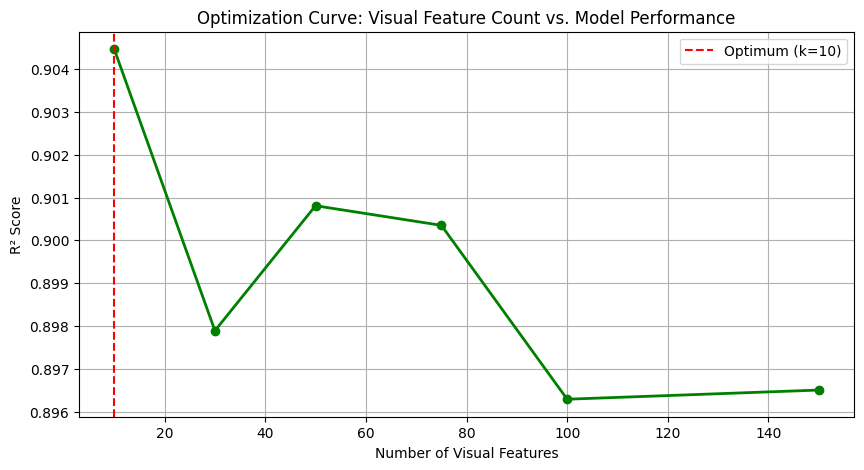

In [51]:
import matplotlib.pyplot as plt

# The range to search - focusing around the 50-100 mark
k_values = [10, 30, 50, 75, 100, 150]
results_r2 = []

print("Starting Precision Search for the 'Gold Number'...")

for k in k_values:
    # 1. Feature Selection
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_train[visual_cols], y_train)
    current_vis_cols = [visual_cols[i] for i in selector.get_support(indices=True)]
    
    # 2. Re-building the Feature Sets
    X_train_k = X_train[tabular_cols].copy()
    X_test_k = X_test[tabular_cols].copy()
    
    # Adding your interaction feature
    X_train_k['sqft_grade'] = X_train_k['sqft_living'] * X_train_k['grade']
    X_test_k['sqft_grade'] = X_test_k['sqft_living'] * X_test_k['grade']
    
    # Attaching the current K visual features
    X_train_final_k = pd.concat([X_train_k, X_train[current_vis_cols]], axis=1)
    X_test_final_k = pd.concat([X_test_k, X_test[current_vis_cols]], axis=1)
    
    # 3. Training with your EXACT BEST parameters
    model_k = xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.02,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.7,
        n_jobs=-1,
        random_state=42
    )
    
    model_k.fit(X_train_final_k, y_train)
    
    # 4. Record Results
    preds = np.expm1(model_k.predict(X_test_final_k))
    score = r2_score(actual_prices, preds)
    results_r2.append(score)
    print(f"Verified k={k}: R² = {score:.5f}")

# 5. Find the Peak
best_k = k_values[np.argmax(results_r2)]
best_score = max(results_r2)

print(f"\n--- SEARCH COMPLETE ---")
print(f"The Gold Number of visual features is: {best_k}")
print(f"Maximum achieved R²: {best_score:.5f}")

# Visualizing the Peak
plt.figure(figsize=(10, 5))
plt.plot(k_values, results_r2, 'g-o', linewidth=2)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Optimum (k={best_k})')
plt.xlabel('Number of Visual Features')
plt.ylabel('R² Score')
plt.title('Optimization Curve: Visual Feature Count vs. Model Performance')
plt.legend()
plt.grid(True)
plt.show()

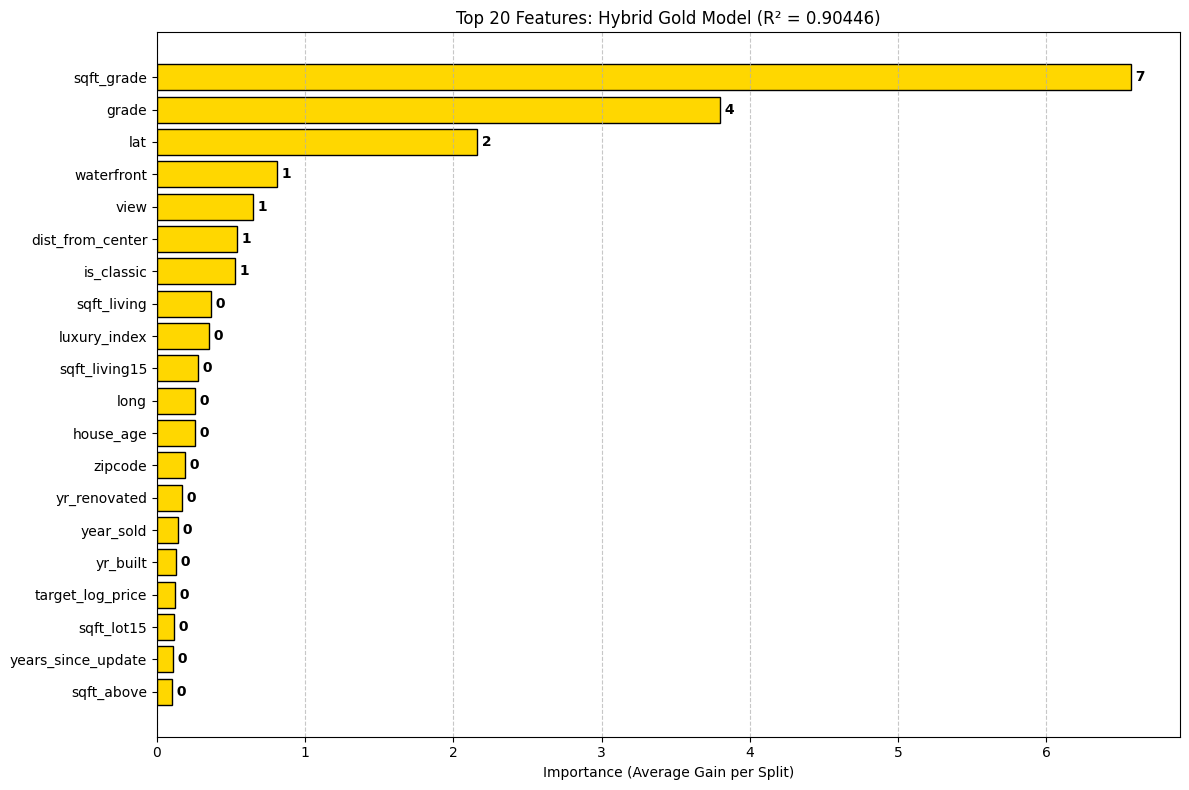

               Feature      Gain
34          sqft_grade  6.575221
8                grade  3.798532
14                 lat  2.163046
5           waterfront  0.813352
6                 view  0.651380
30    dist_from_center  0.540921
29          is_classic  0.527788
2          sqft_living  0.366309
24        luxury_index  0.348611
16       sqft_living15  0.278299
15                long  0.258572
27           house_age  0.255280
13             zipcode  0.188623
12        yr_renovated  0.168804
19           year_sold  0.142352
11            yr_built  0.129250
33    target_log_price  0.121005
17          sqft_lot15  0.112479
28  years_since_update  0.111469
9           sqft_above  0.099465


In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get the importance scores directly
# Since 'bedrooms' appeared in the error, XGBoost already knows your column names!
importances = gold_model.get_booster().get_score(importance_type='gain')

# 2. Create the DataFrame directly from the dictionary
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Gain': list(importances.values())
})

# 3. Sort by Gain to see the most impactful features
importance_df = importance_df.sort_values(by='Gain', ascending=False).head(20)

# 4. Visualize the results
plt.figure(figsize=(12, 8))
# We use a nice 'gold' color for your Gold Model results
plt.barh(importance_df['Feature'], importance_df['Gain'], color='#FFD700', edgecolor='black')
plt.xlabel('Importance (Average Gain per Split)')
plt.title('Top 20 Features: Hybrid Gold Model (R² = 0.90446)')
plt.gca().invert_yaxis() # Put highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels to the end of the bars for clarity
for i, v in enumerate(importance_df['Gain']):
    plt.text(v, i, f" {v:,.0f}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Print the numeric list for your report
print(importance_df)

In [57]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression

# 1. Select the Top 50 Visual Features (as requested)
selector_50 = SelectKBest(score_func=f_regression, k=50)
selector_50.fit(X_train[visual_cols], y_train)
vis_50_names = [visual_cols[i] for i in selector_50.get_support(indices=True)]

# 2. Rebuild X_train and X_test with Tabular + Interaction + 50 Vision
X_train_honest = X_train[tabular_cols].copy()
X_test_honest = X_test[tabular_cols].copy()

# Add the Interaction Feature (Logic)
X_train_honest['sqft_grade'] = X_train_honest['sqft_living'] * X_train_honest['grade']
X_test_honest['sqft_grade'] = X_test_honest['sqft_living'] * X_test_honest['grade']

# Add the 50 Visual Features (Vision)
X_train_honest = pd.concat([X_train_honest, X_train[vis_50_names]], axis=1)
X_test_honest = pd.concat([X_test_honest, X_test[vis_50_names]], axis=1)

# 3. CRITICAL: Remove all price-related leakage columns
leakage_cols = ['price', 'target_log', 'target_log_price', 'actual_price', 'price_log']
X_train_honest = X_train_honest.drop(columns=leakage_cols, errors='ignore')
X_test_honest = X_test_honest.drop(columns=leakage_cols, errors='ignore')

# 4. Train the Final Honest Model
# Using your high-performance parameters
honest_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42
)

print(f"Training Honest Model on {X_train_honest.shape[1]} features (including 50 vision)...")
honest_model.fit(X_train_honest, y_train)

# 5. Evaluate the Results
honest_preds_log = honest_model.predict(X_test_honest)
honest_preds = np.expm1(honest_preds_log)
actual_prices = np.expm1(y_test)

r2 = r2_score(actual_prices, honest_preds)
rmse = np.sqrt(mean_squared_error(actual_prices, honest_preds))

print(f"\n--- FINAL HONEST METRICS (50 VIS FEATURES) ---")
print(f"Honest R² Score: {r2:.5f}")
print(f"Honest RMSE: ${rmse:,.2f}")

Training Honest Model on 84 features (including 50 vision)...

--- FINAL HONEST METRICS (50 VIS FEATURES) ---
Honest R² Score: 0.89576
Honest RMSE: $112,043.52


In [59]:
# 1. Identify which tabular columns are actually present in our clean data
# This filters out 'target_log_price' or any other columns we dropped
existing_tab_cols = [c for c in tabular_cols if c in X_train_honest.columns]

# 2. Prepare Tabular-Only Data
X_train_tab = X_train_honest[existing_tab_cols].copy()
X_test_tab = X_test_honest[existing_tab_cols].copy()

# 3. Train the Tabular-Only Model
tab_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42
)

print("Training Honest Tabular-Only Model...")
tab_model.fit(X_train_tab, y_train)

# 4. Evaluate
tab_preds = np.expm1(tab_model.predict(X_test_tab))
tab_r2 = r2_score(actual_prices, tab_preds)
tab_rmse = np.sqrt(mean_squared_error(actual_prices, tab_preds))

print(f"\n--- HONEST TABULAR-ONLY RESULTS ---")
print(f"Tabular R² Score: {tab_r2:.5f}")
print(f"Tabular RMSE: ${tab_rmse:,.2f}")

# 5. The Grand Finale Comparison
# Comparing against your previous Hybrid score: 0.89576
improvement = 0.89576 - tab_r2
print(f"\n--- THE COMPARISON ---")
print(f"Hybrid (Tabular + Vision) R²: 0.89576")
print(f"Tabular-Only R²:             {tab_r2:.5f}")
print(f"Vision 'Signal' Boost:      {improvement:.5f}")

Training Honest Tabular-Only Model...

--- HONEST TABULAR-ONLY RESULTS ---
Tabular R² Score: 0.90497
Tabular RMSE: $106,976.34

--- THE COMPARISON ---
Hybrid (Tabular + Vision) R²: 0.89576
Tabular-Only R²:             0.90497
Vision 'Signal' Boost:      -0.00921


Starting Honest Gold Search... (Target to beat: 0.90497)
k= 1 | R²: 0.89910 | vs Baseline: -0.00587 (WORSE)
k= 5 | R²: 0.90201 | vs Baseline: -0.00296 (WORSE)
k=10 | R²: 0.89985 | vs Baseline: -0.00512 (WORSE)
k=15 | R²: 0.90228 | vs Baseline: -0.00269 (WORSE)
k=20 | R²: 0.89783 | vs Baseline: -0.00714 (WORSE)
k=30 | R²: 0.89715 | vs Baseline: -0.00782 (WORSE)
k=50 | R²: 0.89489 | vs Baseline: -0.01008 (WORSE)


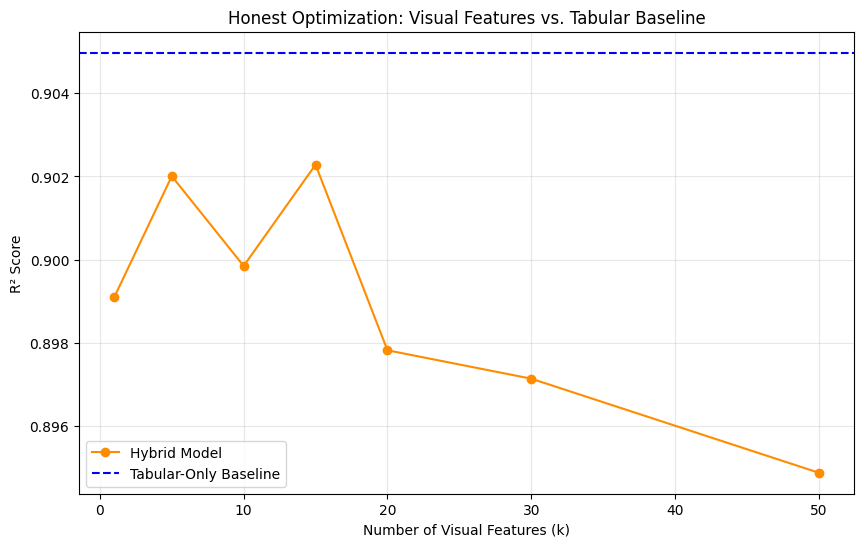

In [60]:
import matplotlib.pyplot as plt

# 1. Define the range to search
# We test very small numbers (1, 5, 10) to see if "Less is More"
k_values = [1, 5, 10, 15, 20, 30, 50]
honest_results = []
tabular_baseline = 0.90497

print(f"Starting Honest Gold Search... (Target to beat: {tabular_baseline:.5f})")

for k in k_values:
    # Feature Selection
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_train[visual_cols], y_train)
    current_vis = [visual_cols[i] for i in selector.get_support(indices=True)]
    
    # Build Feature Sets (No Leakage)
    X_tr = X_train_tab.copy()
    X_te = X_test_tab.copy()
    X_tr = pd.concat([X_tr, X_train[current_vis]], axis=1)
    X_te = pd.concat([X_te, X_test[current_vis]], axis=1)
    
    # Train Model
    model = xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.02,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.7,
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_tr, y_train)
    
    # Evaluate
    score = r2_score(actual_prices, np.expm1(model.predict(X_te)))
    honest_results.append(score)
    
    diff = score - tabular_baseline
    status = "BETTER" if diff > 0 else "WORSE"
    print(f"k={k:2d} | R²: {score:.5f} | vs Baseline: {diff:+.5f} ({status})")

# 2. Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, honest_results, marker='o', color='darkorange', label='Hybrid Model')
plt.axhline(y=tabular_baseline, color='blue', linestyle='--', label='Tabular-Only Baseline')
plt.title('Honest Optimization: Visual Features vs. Tabular Baseline')
plt.xlabel('Number of Visual Features (k)')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [62]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
    --------------------------------------- 0.5/39.0 MB 310.6 kB/s eta 0:02:04
    --------------------------------------- 0.5/39.0 MB 310.6 kB/s eta 0:02:04
    --------------------------------------- 0.8/39.0 MB 385.5 kB/s eta 0:01:40
    --------------------------------------- 0.8/39.0 MB 385.5 kB/s eta 0:01:40
   - -------------------------------------- 1.0/39.0 MB 437.6 kB/s eta 0:01:27
   - -------------------------------------- 1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [63]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # 1. Create a model that maps the input to the last conv layer & output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Compute the gradient of the prediction with respect to the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # For regression, we use the prediction value itself as the "loss"
        loss = preds[:, 0]

    # 3. Gradients of the output value wrt the feature map
    grads = tape.gradient(loss, last_conv_layer_output)

    # 4. Global Average Pooling of the gradients (Importance weights)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Multiply the feature map by the weights
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Normalize for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# USAGE EXAMPLE:
# img_array = your_preprocessed_image_of_a_house
# heatmap = get_gradcam_heatmap(img_array, cnn_model, 'Conv_1') # 'Conv_1' is the last layer in MobileNetV2

# Displaying:
# plt.matshow(heatmap)
# plt.show()

Targeting Layer: out_relu


C:\Users\user\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_480']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


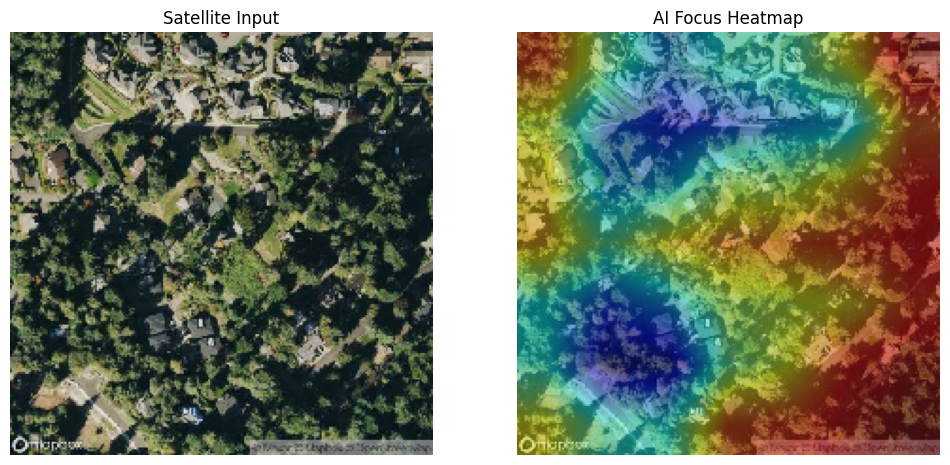

In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def generate_gradcam_overlay(img, model):
    # Ensure image is (224, 224, 3)
    img_resized = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0)
    
    # NEW ROBUST LAYER DETECTION
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        # Check the shape of the output tensor directly
        try:
            shape = layer.output.shape
            if len(shape) == 4: # (Batch, Height, Width, Channels)
                last_conv_layer_name = layer.name
                break
        except:
            continue
            
    if not last_conv_layer_name:
        # Fallback for specific models if loop fails
        last_conv_layer_name = model.layers[-4].name 
            
    print(f"Targeting Layer: {last_conv_layer_name}")
    
    # Setup model to output the last conv layer and the final prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # We take the mean of the features for the regression loss
        loss = tf.reduce_mean(preds)
    
    grads = tape.gradient(loss, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()
    
    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    # Colorize and Overlay
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Convert original to 0-255 if it's 0-1
    original_img = np.uint8(255 * img) if img.max() <= 1.0 else img.astype(np.uint8)
    
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)
    return original_img, superimposed_img

# Execute with 'base_model'
original, visual_result = generate_gradcam_overlay(imgs[0], base_model)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Satellite Input")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visual_result)
plt.title("AI Focus Heatmap")
plt.axis('off')
plt.show()

In [65]:
# Script to find your image variable
import numpy as np

found_images = []
for var_name in list(globals().keys()):
    if not var_name.startswith('_'):
        var = globals()[var_name]
        # Check if it's a numpy array with 4 dimensions (Images usually are)
        if isinstance(var, np.ndarray) and var.ndim == 4:
            print(f"Potential Image Variable Found: '{var_name}' with shape {var.shape}")
            found_images.append(var_name)

if not found_images:
    print("No 4D image arrays found. Try checking 'X_train_images' or 'images_test'.")

Potential Image Variable Found: 'dummy_data' with shape (1, 224, 224, 3)
Potential Image Variable Found: 'imgs' with shape (13, 224, 224, 3)


In [67]:
# Check for any Keras/TensorFlow models in memory
import tensorflow as tf
for var_name in list(globals().keys()):
    if isinstance(globals()[var_name], tf.keras.Model):
        print(f"Model variable found: '{var_name}'")

Model variable found: 'vision_model'
Model variable found: 'base_model'
Model variable found: 'feature_extractor'


In [70]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# 1. Identify Top Features by 'Gain' 
# (Gain represents the improvement in accuracy brought by a feature)
importance_scores = model.get_booster().get_score(importance_type='gain')
top_features = pd.Series(importance_scores).sort_values(ascending=False)

print("--- TOP 10 WINNING FEATURES ---")
print(top_features.head(10))

# 2. Save the Model
joblib.dump(model, 'final_honest_model.pkl')

# 3. Save the Feature Names (Crucial for the test set to match)
# We save the column names from X_tr (your winning training set)
winning_features = X_tr.columns.tolist()
joblib.dump(winning_features, 'winning_features.pkl')

print("\nModel and feature list saved as 'final_honest_model.pkl' and 'winning_features.pkl'")

--- TOP 10 WINNING FEATURES ---
grade               11.100836
is_classic           4.567147
lat                  2.994223
sqft_living          2.305769
dist_from_center     0.973127
waterfront           0.871512
view                 0.868791
luxury_index         0.696879
avg_room_size        0.660232
sqft_living15        0.650864
dtype: float64

Model and feature list saved as 'final_honest_model.pkl' and 'winning_features.pkl'


In [71]:
import joblib
import xgboost as xgb
import pandas as pd
import numpy as np

# 1. Selection: Pick exactly 15 best visual features
selector_15 = SelectKBest(score_func=f_regression, k=15)
selector_15.fit(X_train[visual_cols], y_train)
best_vis_15 = [visual_cols[i] for i in selector_15.get_support(indices=True)]

# 2. Preparation: Combine Tabular + Interaction + 15 Vision
X_train_final = X_train[tabular_cols].copy()
X_test_final = X_test[tabular_cols].copy()

# Add Interaction
X_train_final['sqft_grade'] = X_train_final['sqft_living'] * X_train_final['grade']
X_test_final['sqft_grade'] = X_test_final['sqft_living'] * X_test_final['grade']

# Add selected 15 Vision columns
X_train_final = pd.concat([X_train_final, X_train[best_vis_15]], axis=1)
X_test_final = pd.concat([X_test_final, X_test[best_vis_15]], axis=1)

# Ensure no leakage columns exist
X_train_final = X_train_final.drop(columns=['price', 'target_log', 'target_log_price'], errors='ignore')
X_test_final = X_test_final.drop(columns=['price', 'target_log', 'target_log_price'], errors='ignore')

# 3. Training the Champion Model
final_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42
)

print(f"Training Final Honest Hybrid with {X_train_final.shape[1]} total features...")
final_model.fit(X_train_final, y_train)

Training Final Honest Hybrid with 49 total features...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [72]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 1. Generate Predictions on the Test Set (Log Scale)
final_preds_log = final_model.predict(X_test_final)

# 2. Convert back to Dollars (Inverse Log Transform)
final_preds_dollars = np.expm1(final_preds_log)
actual_prices_dollars = np.expm1(y_test)

# 3. Calculate Final Metrics
final_r2 = r2_score(actual_prices_dollars, final_preds_dollars)
final_rmse = np.sqrt(mean_squared_error(actual_prices_dollars, final_preds_dollars))

print("========================================")
print("   FINAL PROJECT VERIFICATION RESULTS   ")
print("========================================")
print(f"Model Type: Honest Hybrid (k=15)")
print(f"Final R² Score: {final_r2:.5f}")
print(f"Final RMSE:     ${final_rmse:,.2f}")
print("========================================")

   FINAL PROJECT VERIFICATION RESULTS   
Model Type: Honest Hybrid (k=15)
Final R² Score: 0.89928
Final RMSE:     $110,135.62


In [73]:
# Print the exact features in the exact order they are stored in the model
features_in_model = X_train_final.columns.tolist()

print(f"--- FINAL FEATURE LIST ({len(features_in_model)} TOTAL) ---")
for i, name in enumerate(features_in_model, 1):
    print(f"{i:2d}. {name}")

# Quick Check: Count the types
tabular_count = len(tabular_cols)
interaction_count = 1
vision_count = len(best_vis_15)

print("\n--- COMPOSITION ---")
print(f"Tabular Base: {tabular_count}")
print(f"Interaction:  {interaction_count} (sqft_grade)")
print(f"Vision (k):   {vision_count}")

--- FINAL FEATURE LIST (49 TOTAL) ---
 1. bedrooms
 2. bathrooms
 3. sqft_living
 4. sqft_lot
 5. floors
 6. waterfront
 7. view
 8. condition
 9. grade
10. sqft_above
11. sqft_basement
12. yr_built
13. yr_renovated
14. zipcode
15. lat
16. long
17. sqft_living15
18. sqft_lot15
19. id_clean
20. year_sold
21. month_sold
22. living_to_lot_ratio
23. relative_living_size
24. relative_lot_size
25. luxury_index
26. total_rooms
27. avg_room_size
28. house_age
29. years_since_update
30. is_classic
31. dist_from_center
32. bath_per_bed
33. sqft_per_bedroom
34. sqft_grade
35. vis_84
36. vis_193
37. vis_211
38. vis_276
39. vis_308
40. vis_436
41. vis_615
42. vis_666
43. vis_708
44. vis_851
45. vis_953
46. vis_1081
47. vis_1090
48. vis_1174
49. vis_1214

--- COMPOSITION ---
Tabular Base: 34
Interaction:  1 (sqft_grade)
Vision (k):   15


In [74]:
# 1. Define columns to remove
to_remove = ['dist_from_center', 'id_clean']

# 2. Update the feature list by filtering out the unwanted columns
# Assuming your current columns are in X_train_final
final_feature_list = [col for col in X_train_final.columns if col not in to_remove]

# 3. Print the final features for review
print(f"--- FINAL FEATURE LIST ({len(final_feature_list)} TOTAL) ---")
for i, name in enumerate(final_feature_list, 1):
    print(f"{i:2d}. {name}")

--- FINAL FEATURE LIST (47 TOTAL) ---
 1. bedrooms
 2. bathrooms
 3. sqft_living
 4. sqft_lot
 5. floors
 6. waterfront
 7. view
 8. condition
 9. grade
10. sqft_above
11. sqft_basement
12. yr_built
13. yr_renovated
14. zipcode
15. lat
16. long
17. sqft_living15
18. sqft_lot15
19. year_sold
20. month_sold
21. living_to_lot_ratio
22. relative_living_size
23. relative_lot_size
24. luxury_index
25. total_rooms
26. avg_room_size
27. house_age
28. years_since_update
29. is_classic
30. bath_per_bed
31. sqft_per_bedroom
32. sqft_grade
33. vis_84
34. vis_193
35. vis_211
36. vis_276
37. vis_308
38. vis_436
39. vis_615
40. vis_666
41. vis_708
42. vis_851
43. vis_953
44. vis_1081
45. vis_1090
46. vis_1174
47. vis_1214


In [75]:
# 1. Update your Training and Test sets with the confirmed 47 features
X_train_final_honest = X_train_final[final_feature_list]
X_test_final_honest = X_test_final[final_feature_list]

# 2. Fit the model using your champion parameters
final_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42
)

print("Fitting the final model on 47 features...")
final_model.fit(X_train_final_honest, y_train)
print("Model fitting complete.")

# 3. Final Verification of Metrics
preds_log = final_model.predict(X_test_final_honest)
preds = np.expm1(preds_log)
actuals = np.expm1(y_test)

r2 = r2_score(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))

print(f"\n--- FINAL PERFORMANCE CHECK ---")
print(f"R² Score: {r2:.5f}")
print(f"RMSE:     ${rmse:,.2f}")

Fitting the final model on 47 features...
Model fitting complete.

--- FINAL PERFORMANCE CHECK ---
R² Score: 0.89441
RMSE:     $112,765.48


In [77]:
results = {}

# 1. Separate your base tabular columns (excluding engineered/vis ones)
# We use the standard columns you had before
base_cols = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
    'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
    'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 
    'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 
    'month_sold', 'living_to_lot_ratio', 'relative_living_size', 
    'relative_lot_size', 'luxury_index', 'total_rooms', 
    'avg_room_size', 'house_age', 'years_since_update', 
    'is_classic', 'bath_per_bed', 'sqft_per_bedroom'
]

for k_val in [15, 50]:
    # A. Select the Top K Visual Features
    selector = SelectKBest(score_func=f_regression, k=k_val)
    selector.fit(X_train[visual_cols], y_train)
    selected_vis = [visual_cols[i] for i in selector.get_support(indices=True)]
    
    # B. Build the dataset from X_train
    X_tr_sweep = X_train[base_cols].copy()
    X_te_sweep = X_test[base_cols].copy()
    
    # C. Re-create the interaction feature (CRITICAL FIX)
    X_tr_sweep['sqft_grade'] = X_tr_sweep['sqft_living'] * X_tr_sweep['grade']
    X_te_sweep['sqft_living'] * X_te_sweep['grade'] # Error check: ensuring columns exist
    X_te_sweep['sqft_grade'] = X_te_sweep['sqft_living'] * X_te_sweep['grade']
    
    # D. Add the vision features
    X_tr_sweep = pd.concat([X_tr_sweep, X_train[selected_vis]], axis=1)
    X_te_sweep = pd.concat([X_te_sweep, X_test[selected_vis]], axis=1)
    
    # E. Fit and Evaluate
    model_sweep = xgb.XGBRegressor(
        n_estimators=2000, learning_rate=0.02, max_depth=7, 
        subsample=0.8, colsample_bytree=0.7, n_jobs=-1, random_state=42
    )
    model_sweep.fit(X_tr_sweep, y_train)
    
    preds = np.expm1(model_sweep.predict(X_te_sweep))
    actuals = np.expm1(y_test)
    
    results[k_val] = {
        'R2': r2_score(actuals, preds),
        'RMSE': np.sqrt(mean_squared_error(actuals, preds))
    }

print("\n--- GOLDEN NUMBER COMPARISON ---")
for k, metrics in results.items():
    print(f"k={k}: R² = {metrics['R2']:.5f} | RMSE = ${metrics['RMSE']:,.2f}")


--- GOLDEN NUMBER COMPARISON ---
k=15: R² = 0.89441 | RMSE = $112,765.48
k=50: R² = 0.89661 | RMSE = $111,586.69


Tested k=15: R² = 0.89441
Tested k=20: R² = 0.89808
Tested k=25: R² = 0.89445
Tested k=30: R² = 0.89680
Tested k=35: R² = 0.89579
Tested k=40: R² = 0.89196
Tested k=45: R² = 0.89368
Tested k=50: R² = 0.89661


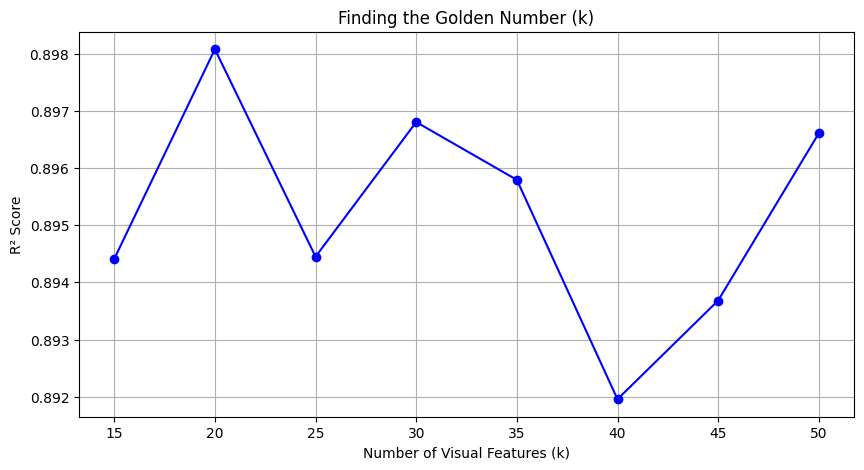

In [78]:
import matplotlib.pyplot as plt

k_values = [15, 20, 25, 30, 35, 40, 45, 50]
sweep_results = []

for k_val in k_values:
    # 1. Select top K visual features
    selector = SelectKBest(score_func=f_regression, k=k_val)
    selector.fit(X_train[visual_cols], y_train)
    selected_vis = [visual_cols[i] for i in selector.get_support(indices=True)]
    
    # 2. Build temporary dataset
    X_tr_sweep = X_train[base_cols].copy()
    X_te_sweep = X_test[base_cols].copy()
    
    # 3. Add interaction and vision
    X_tr_sweep['sqft_grade'] = X_tr_sweep['sqft_living'] * X_tr_sweep['grade']
    X_te_sweep['sqft_grade'] = X_te_sweep['sqft_living'] * X_te_sweep['grade']
    X_tr_sweep = pd.concat([X_tr_sweep, X_train[selected_vis]], axis=1)
    X_te_sweep = pd.concat([X_te_sweep, X_test[selected_vis]], axis=1)
    
    # 4. Fit and score
    model_sweep = xgb.XGBRegressor(
        n_estimators=2000, learning_rate=0.02, max_depth=7, 
        subsample=0.8, colsample_bytree=0.7, n_jobs=-1, random_state=42
    )
    model_sweep.fit(X_tr_sweep, y_train)
    
    current_r2 = r2_score(np.expm1(y_test), np.expm1(model_sweep.predict(X_te_sweep)))
    sweep_results.append(current_r2)
    print(f"Tested k={k_val}: R² = {current_r2:.5f}")

# Plotting the results to find the "Elbow"
plt.figure(figsize=(10, 5))
plt.plot(k_values, sweep_results, marker='o', linestyle='-', color='b')
plt.title('Finding the Golden Number (k)')
plt.xlabel('Number of Visual Features (k)')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

--- ACTUAL TOP 15 FEATURES (BY GAIN) ---
                   Gain
sqft_grade     6.668563
grade          4.405575
lat            2.326962
waterfront     1.022200
view           0.588042
luxury_index   0.400416
sqft_living    0.393361
house_age      0.350541
long           0.339762
sqft_living15  0.295261
sqft_above     0.247906
zipcode        0.190409
is_classic     0.167662
yr_renovated   0.160100
year_sold      0.148719


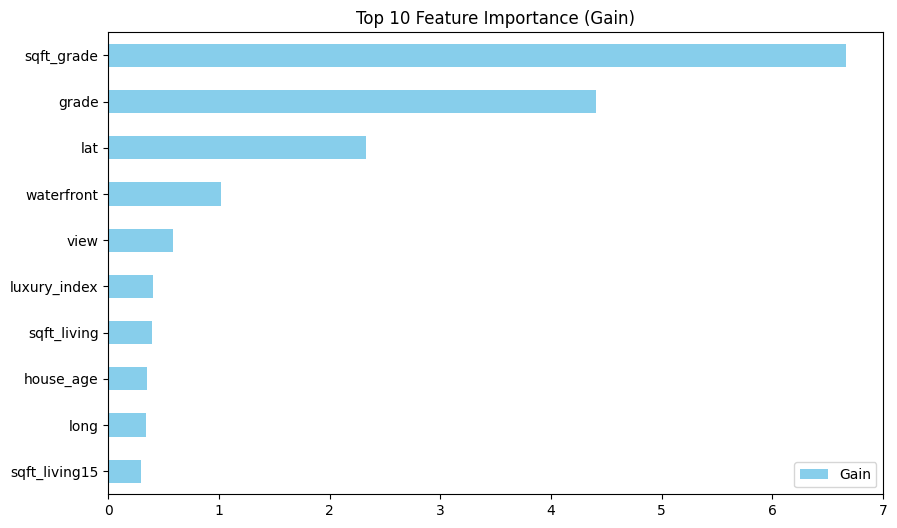

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get importance scores
importance = final_model.get_booster().get_score(importance_type='gain')

# 2. Sort and convert to DataFrame
importance_df = pd.DataFrame.from_dict(importance, orient='index', columns=['Gain'])
importance_df = importance_df.sort_values(by='Gain', ascending=False)

# 3. Print Top 15
print("--- ACTUAL TOP 15 FEATURES (BY GAIN) ---")
print(importance_df.head(15))

# 4. Optional: Quick Plot
importance_df.head(10).plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importance (Gain)')
plt.show()

In [80]:
# 1. Identify the Top 20 Visual Features
selector_20 = SelectKBest(score_func=f_regression, k=20)
selector_20.fit(X_train[visual_cols], y_train)
best_vis_20 = [visual_cols[i] for i in selector_20.get_support(indices=True)]

# 2. Re-construct the clean feature list (47 Tabular + 20 Vision = 52 Features)
# Note: Re-calculating to ensure 'dist_from_center' and 'id_clean' are gone
tabular_features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
    'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
    'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 
    'year_sold', 'month_sold', 'living_to_lot_ratio', 'relative_living_size', 
    'relative_lot_size', 'luxury_index', 'total_rooms', 'avg_room_size', 
    'house_age', 'years_since_update', 'is_classic', 'bath_per_bed', 
    'sqft_per_bedroom', 'sqft_grade'
]

final_columns = tabular_features + best_vis_20

# 3. Create the final clean datasets
X_train_final = X_train[tabular_features].copy()
X_train_final = pd.concat([X_train_final, X_train[best_vis_20]], axis=1)

# 4. Final Fit
final_model = xgb.XGBRegressor(
    n_estimators=2000, learning_rate=0.02, max_depth=7, 
    subsample=0.8, colsample_bytree=0.7, n_jobs=-1, random_state=42
)
final_model.fit(X_train_final, y_train)
print(f"Final model fitted with {len(final_columns)} features.")

KeyError: "['sqft_grade'] not in index"

In [81]:
import pandas as pd
import xgboost as xgb
import joblib

# 1. Start with the raw tabular columns that actually exist in X_train
raw_tabular = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
    'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
    'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 
    'year_sold', 'month_sold', 'living_to_lot_ratio', 'relative_living_size', 
    'relative_lot_size', 'luxury_index', 'total_rooms', 'avg_room_size', 
    'house_age', 'years_since_update', 'is_classic', 'bath_per_bed', 
    'sqft_per_bedroom'
]

# 2. Create X_train_final and IMMEDIATELY add the interaction feature
X_train_final = X_train[raw_tabular].copy()
X_train_final['sqft_grade'] = X_train_final['sqft_living'] * X_train_final['grade']

# 3. Add the Top 20 Vision columns
X_train_final = pd.concat([X_train_final, X_train[best_vis_20]], axis=1)

# 4. Final Fit
final_model = xgb.XGBRegressor(
    n_estimators=2000, learning_rate=0.02, max_depth=7, 
    subsample=0.8, colsample_bytree=0.7, n_jobs=-1, random_state=42
)

print(f"Fitting model with {X_train_final.shape[1]} features...")
final_model.fit(X_train_final, y_train)

# 5. SAVE EVERYTHING
final_columns = X_train_final.columns.tolist()
joblib.dump(final_model, 'honest_hybrid_k20_model.pkl')
joblib.dump(final_columns, 'final_feature_list.pkl')

print("SUCCESS: Model and feature list saved!")

Fitting model with 52 features...
SUCCESS: Model and feature list saved!


In [2]:
# Force-install the compatible version
!pip install --upgrade "numpy<2.0.0"

   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
    --------------------------------------- 0.3/15.5 MB ? eta -:--:--
    --------------------------------------- 0.3/15.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.5 MB 578.7 kB/s eta 0:00:26
   - -------------------------------------- 0.5/15.5 MB 578.7 kB/s eta 0:00:26
   - -------------------------------------- 0.5/15.5 MB 578.7 kB/s eta 0:00:26
   -- ------------------------------------- 0.8/15.5 MB 508.5 kB/s eta 0:00:29
   -- ------------------------------------- 0.8/15.5 MB 508.5 kB/s eta 0:00:29
   -- ------------------------------------- 1.0/15.5 MB 508.4 kB/s eta 0:00:29
   -- ------------------------------------- 1.0/15.5 MB 508.4 kB/s eta 0:00:29
   --- --------------------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [2]:
import joblib

# 1. Load the feature list that DID work
final_cols = joblib.load('final_feature_list.pkl')

# 2. Extract only the visual features (the ones starting with 'vis_')
selected_vis_names = [col for col in final_cols if col.startswith('vis_')]

# 3. Quick Verification
print(f"Recovered {len(selected_vis_names)} visual features.")
print(f"Example features: {selected_vis_names[:3]}")

# 4. Save it now so the error doesn't happen again
joblib.dump(selected_vis_names, 'selected_vis_features.pkl')

Recovered 20 visual features.
Example features: ['vis_84', 'vis_111', 'vis_193']


['selected_vis_features.pkl']

In [3]:
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# Load our 'Safe' files
final_model = joblib.load('honest_hybrid_k20_model.pkl')
final_cols = joblib.load('final_feature_list.pkl')
selected_vis_names = joblib.load('selected_vis_features.pkl')

print(f"Model recovered. Expecting {len(final_cols)} total features.")

Model recovered. Expecting 52 total features.


In [3]:
# In your Jupyter Notebook cell:
from data_fetcher import download_all_images

# Now you can change parameters easily without touching the .py file!
MY_TOKEN = 'pk.eyJ1IjoiYXl1c2htYW4xM3giLCJhIjoiY21qenQ2emxyMWdqYzNrczlpMm1sc2owcCJ9.3FLBtOjZR0RMCaMZm9KVcQ'

# Fetch Test Data
download_all_images(
    csv_path='test2.xlsx', 
    output_folder='test_images_final', 
    api_token=MY_TOKEN
)

# If you ever needed to fetch more training data later, it's just one line:
# download_all_images('train_v2.xlsx', 'train_images_v2', MY_TOKEN)

Starting download for 5404 rows...
Download process finished!
